In [153]:
import tensorflow as tf

# Проверка устройства
print("TensorFlow version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# Вывод используемых устройств
tf.config.experimental.list_physical_devices()

TensorFlow version: 2.17.1
GPU is NOT AVAILABLE


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [114]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Input, SimpleRNN, GRU
%matplotlib inline

# **Data Ingestion**

In [115]:
# read training data
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [116]:
# read test data
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [117]:
# read ground truth data
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [118]:
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


# **Data Preprocessing**

In [119]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [120]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [121]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [122]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


In [123]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [124]:
# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [125]:
# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


# **Modelling**

In [126]:
# pick a large window size of 50 cycles
sequence_length = 50

In [127]:
# preparing data for visualizations
# window of 50 cycles prior to a failure point for engine id 14
engine_id14 = test_df[test_df['id'] == 14]
engine_id14_50cycleWindow = engine_id14[engine_id14['RUL'] <= engine_id14['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id14_50cycleWindow1 = engine_id14_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id14_50cycleWindow2 = engine_id14_50cycleWindow[cols2]

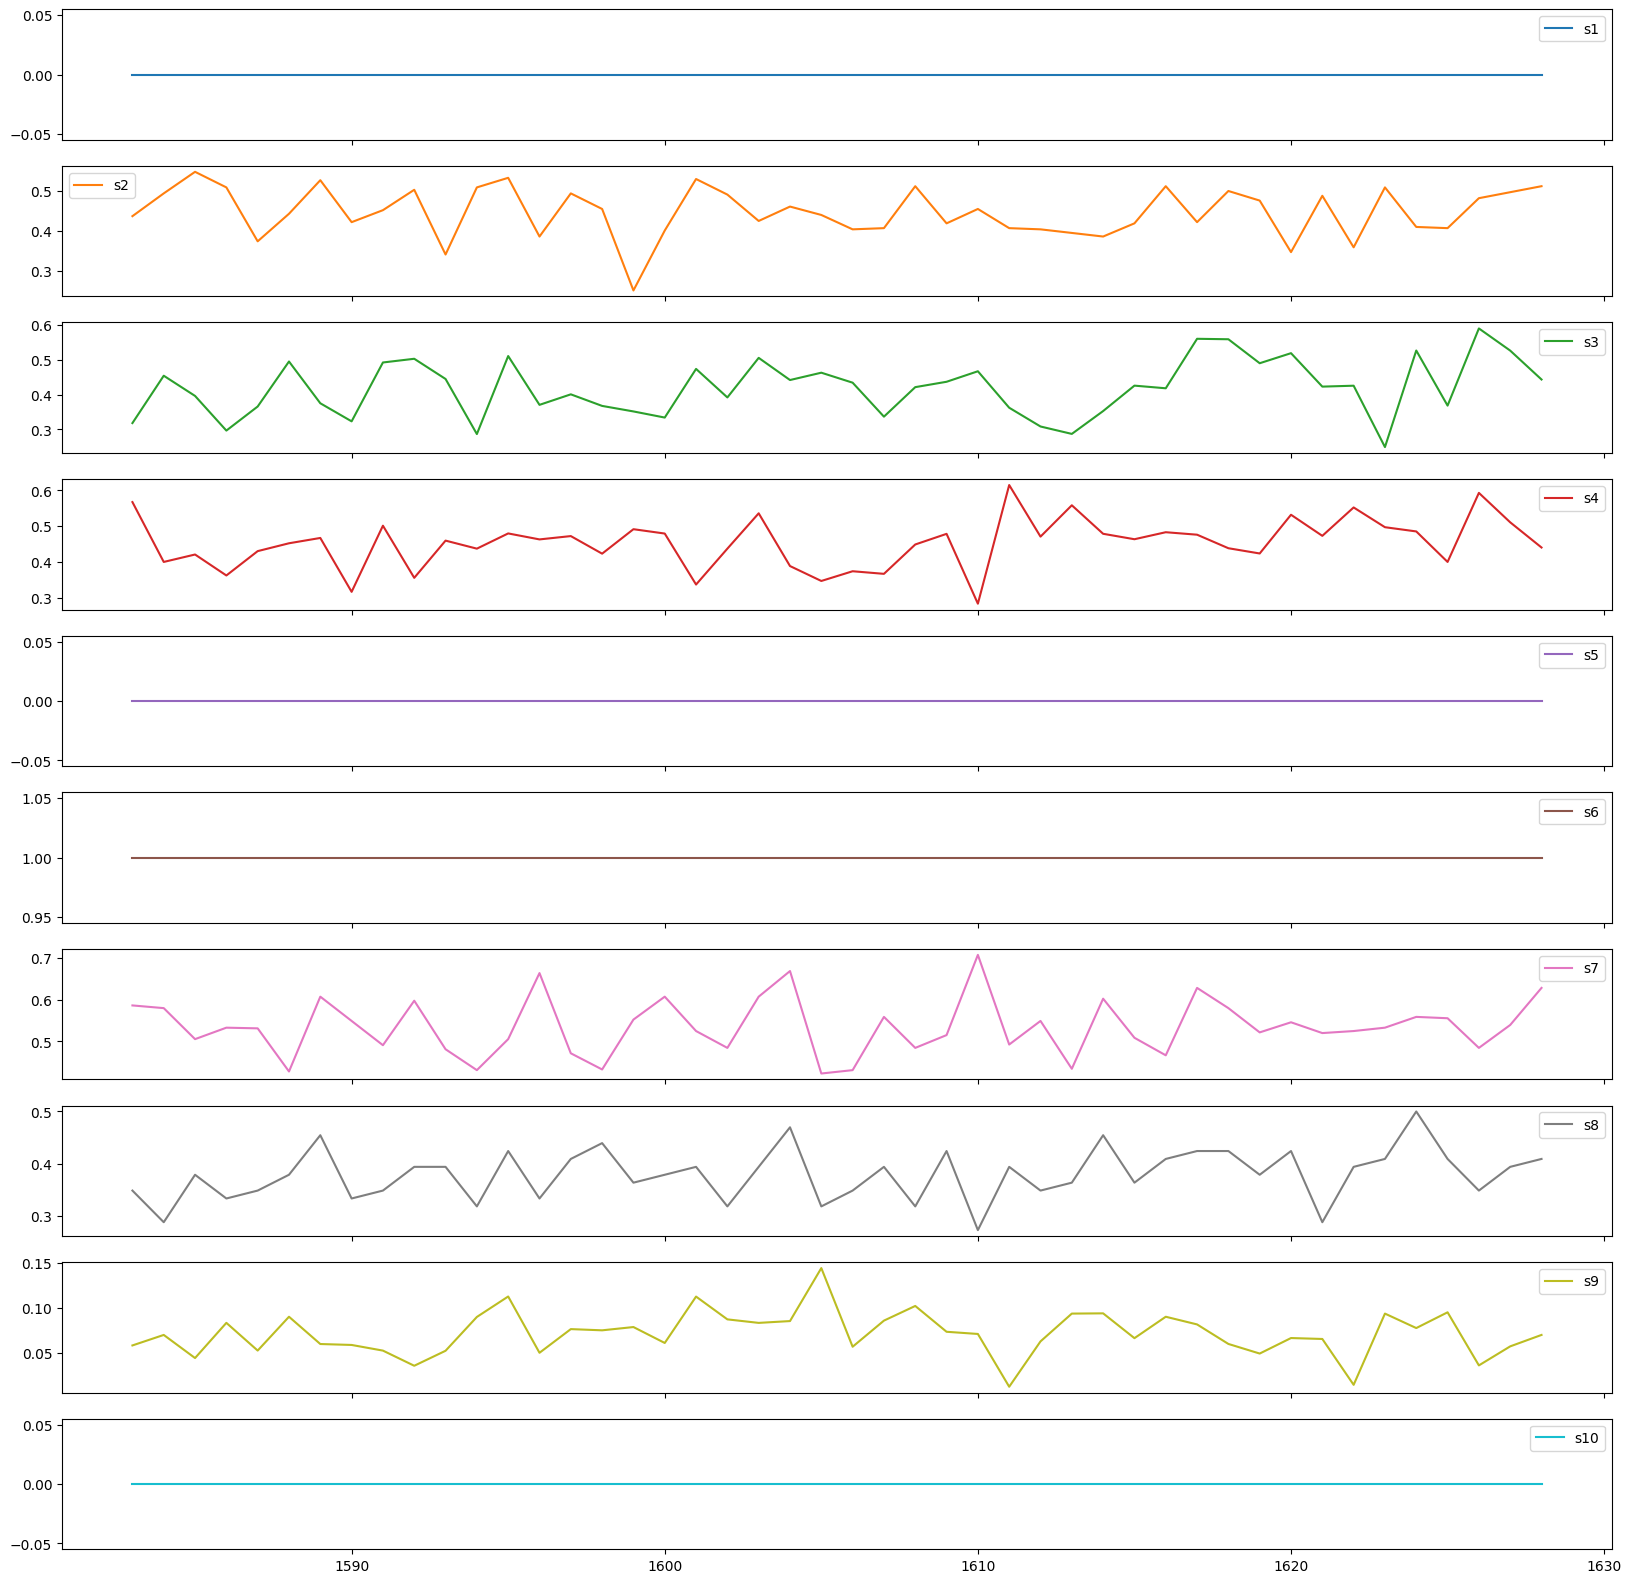

In [128]:
# plotting sensor data for engine ID 14 prior to a failure point - sensors 1-10
ax1 = engine_id14_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

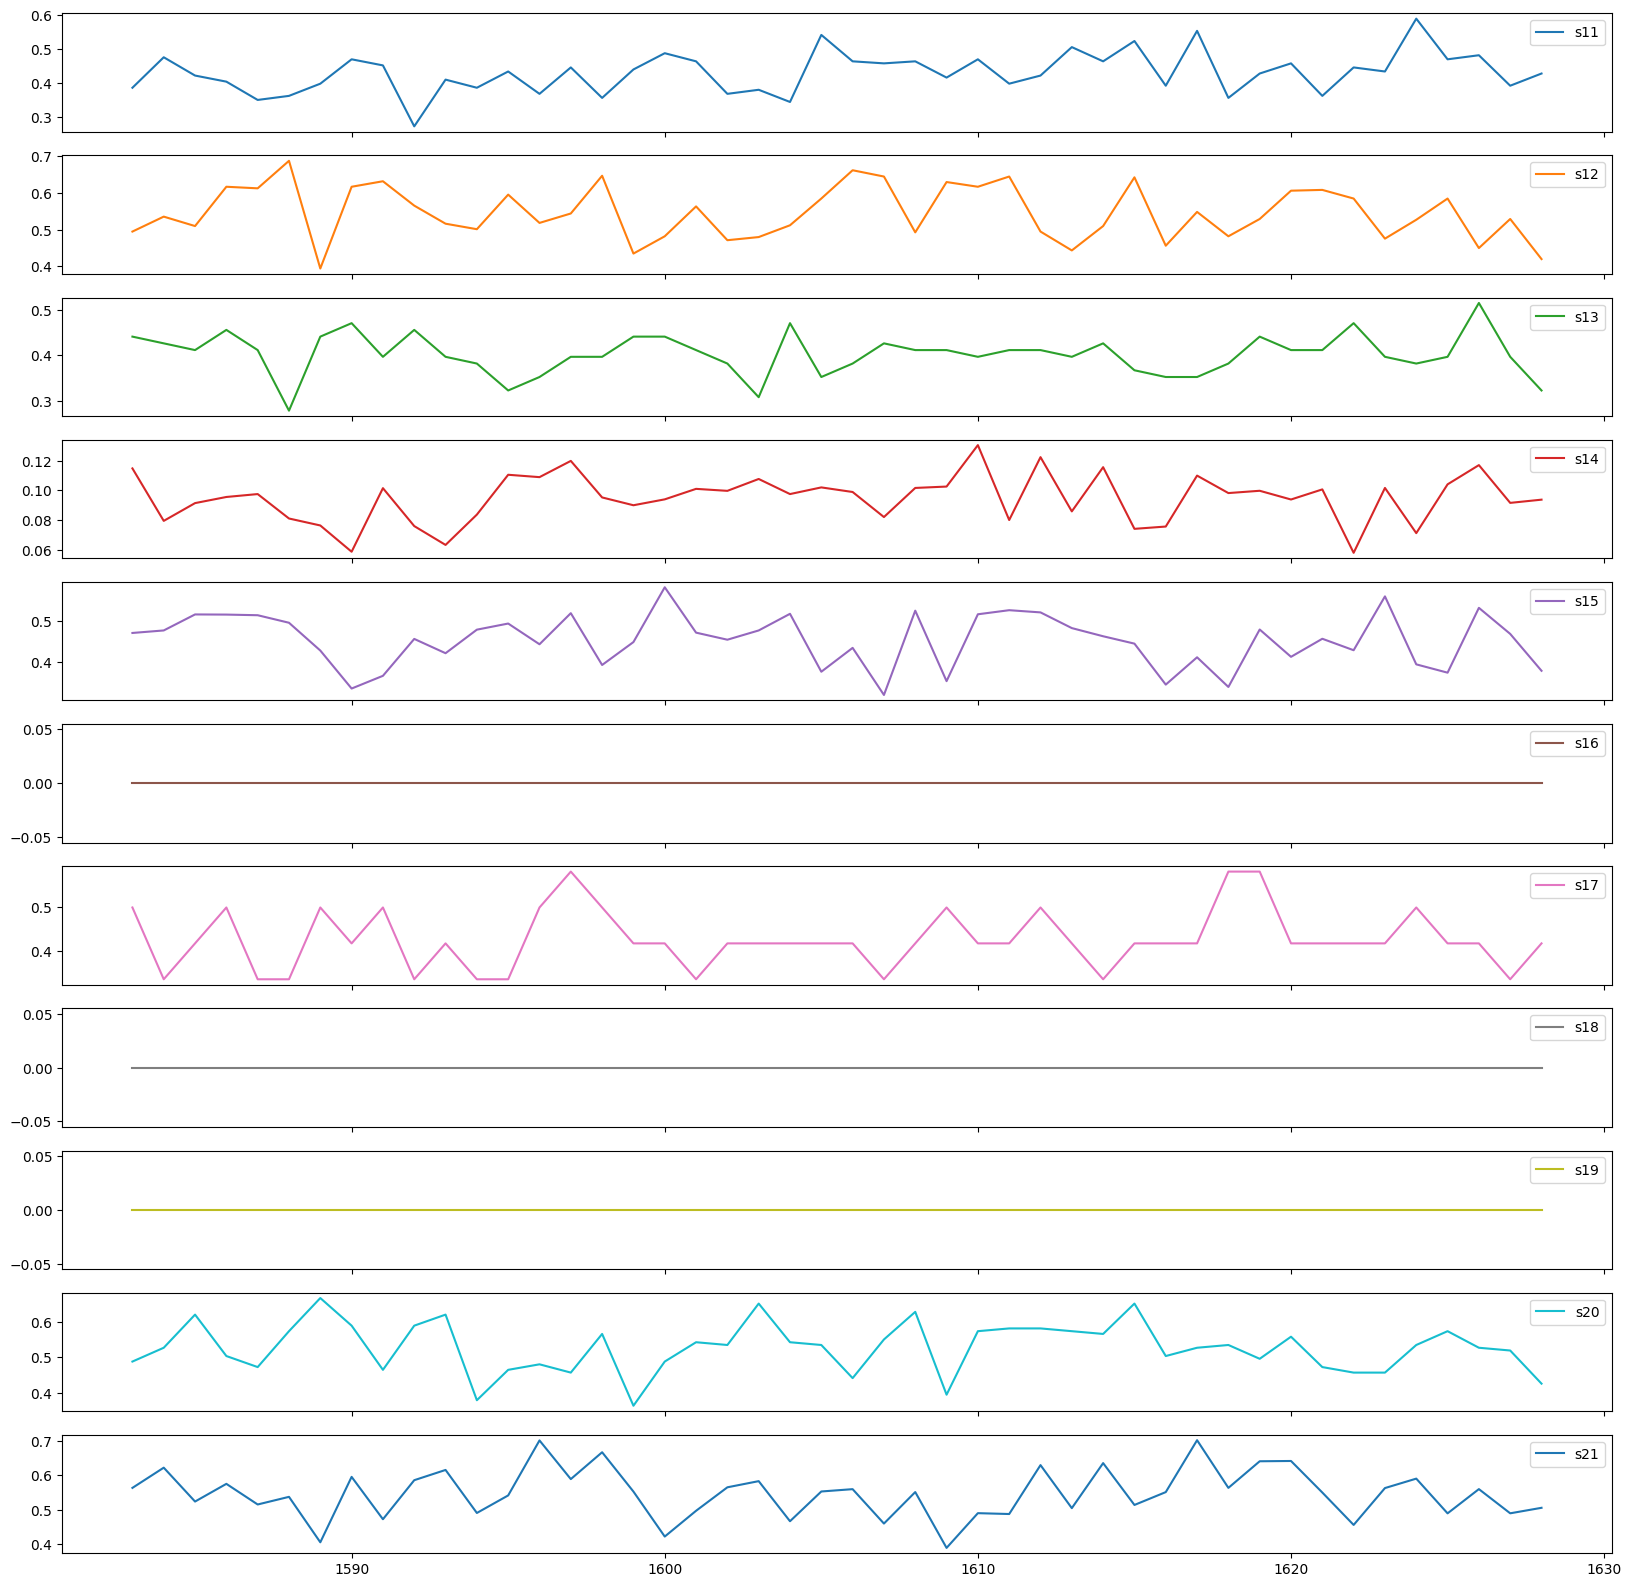

In [129]:
# plotting sensor data for engine ID 14 prior to a failure point - sensors 11-21
ax2 = engine_id14_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [130]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [131]:
# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [132]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

In [133]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [134]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [135]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [136]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

In [137]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [138]:
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# **Pipeline**

In [139]:
def pipeline(model):
  res = {}
  history = model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

  # train
  y_prob = model.predict(seq_array,verbose=1, batch_size=200)
  y_pred = (y_prob > 0.5).astype(int).flatten()
  y_true = label_array
  loss, accuracy = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = 2 * (precision * recall) / (precision + recall)
  cm = confusion_matrix(y_true, y_pred)

  res['train'] = [accuracy, precision, recall, f1, loss]

  # test
  y_prob = model.predict(seq_array_test_last)
  y_pred = (y_prob > 0.5).astype(int).flatten()
  y_true = label_array_test_last
  loss, accuracy = model.evaluate(seq_array_test_last, label_array_test_last, verbose=1, batch_size=200)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = 2 * (precision * recall) / (precision + recall)
  cm = confusion_matrix(y_true, y_pred)

  res['test'] = [accuracy, precision, recall, f1, loss]

  # Достаем данные из истории
  loss = history.history['loss']          # Потери на обучающей выборке
  val_loss = history.history['val_loss']  # Потери на валидационной выборке
  accuracy = history.history['accuracy']  # Точность на обучающей выборке
  val_accuracy = history.history['val_accuracy']  # Точность на валидационной выборке

  # Создаем фигуру с двумя графиками (subplots)
  fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 строка, 2 столбца

  # График Loss
  ax[0].plot(loss, label='Train Loss', marker='o')
  ax[0].plot(val_loss, label='Validation Loss', marker='o')
  ax[0].set_title('Loss Over Epochs')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  ax[0].grid()

  # График Accuracy
  ax[1].plot(accuracy, label='Train Accuracy', marker='o')
  ax[1].plot(val_accuracy, label='Validation Accuracy', marker='o')
  ax[1].set_title('Accuracy Over Epochs')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()
  ax[1].grid()

  # Показываем оба графика
  plt.tight_layout()  # Автоматически подстраивает расстояния между графиками
  plt.show()

  return res

# **LSTM Network**

In [140]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(Input(shape=(sequence_length, nb_features)))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [141]:
print(model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 50, 100)             │          50,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.8575 - loss: 0.3544 - val_accuracy: 0.9450 - val_loss: 0.1265
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 245ms/step - accuracy: 0.9564 - loss: 0.1091 - val_accuracy: 0.9629 - val_loss: 0.0719
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.9632 - loss: 0.0897 - val_accuracy: 0.9706 - val_loss: 0.0577
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 256ms/step - accuracy: 0.9708 - loss: 0.0708 - val_accuracy: 0.9706 - val_loss: 0.0592
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.9676 - loss: 0.0758
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9570 - loss: 0.1174


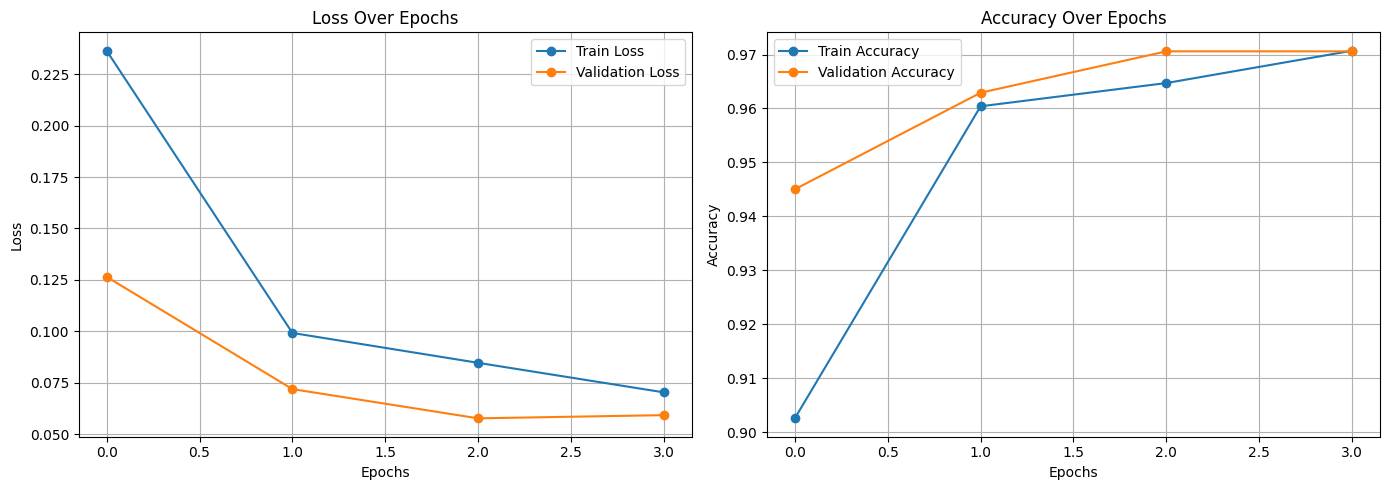

CPU times: user 2min 15s, sys: 6.09 s, total: 2min 22s
Wall time: 1min 40s


In [142]:
%%time
keras.utils.set_random_seed(1234)
LSTM1234 = pipeline(model)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 234ms/step - accuracy: 0.9705 - loss: 0.0709 - val_accuracy: 0.9322 - val_loss: 0.1087
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step - accuracy: 0.9669 - loss: 0.0759 - val_accuracy: 0.9488 - val_loss: 0.1281
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9428 - loss: 0.1412
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9032 - loss: 0.1950


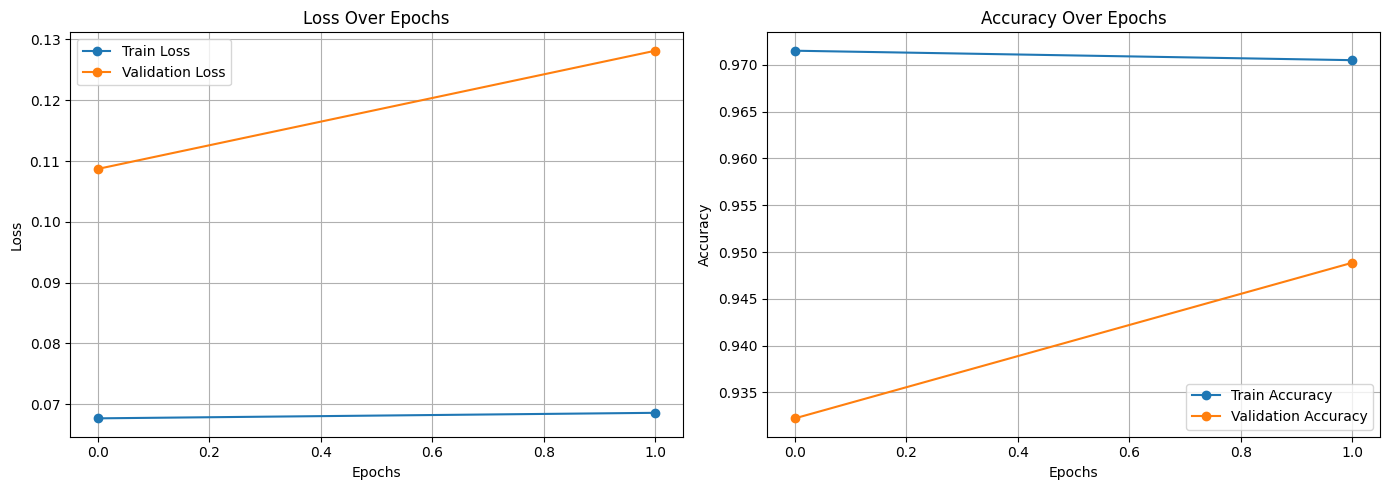

CPU times: user 1min 17s, sys: 3.76 s, total: 1min 21s
Wall time: 1min


In [143]:
%%time
keras.utils.set_random_seed(1159)
LSTM1159 = pipeline(model)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 254ms/step - accuracy: 0.9632 - loss: 0.0863 - val_accuracy: 0.9795 - val_loss: 0.0517
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 232ms/step - accuracy: 0.9760 - loss: 0.0591 - val_accuracy: 0.9821 - val_loss: 0.0367
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 253ms/step - accuracy: 0.9768 - loss: 0.0569 - val_accuracy: 0.9770 - val_loss: 0.0523
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.9689 - loss: 0.0743
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9785 - loss: 0.0796


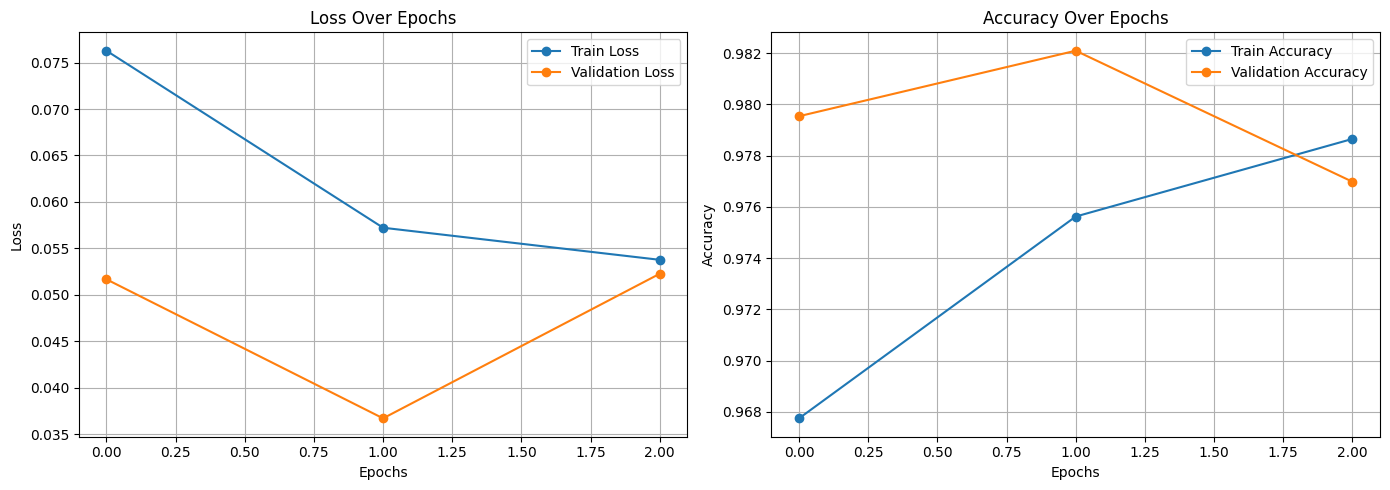

CPU times: user 1min 44s, sys: 4.83 s, total: 1min 49s
Wall time: 1min 20s


In [144]:
%%time
keras.utils.set_random_seed(5858)
LSTM5858 = pipeline(model)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.9754 - loss: 0.0605 - val_accuracy: 0.9821 - val_loss: 0.0457
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 326ms/step - accuracy: 0.9772 - loss: 0.0519 - val_accuracy: 0.9783 - val_loss: 0.0438
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 235ms/step - accuracy: 0.9790 - loss: 0.0509 - val_accuracy: 0.9821 - val_loss: 0.0407
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.9785 - loss: 0.0505 - val_accuracy: 0.9795 - val_loss: 0.0452
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - accuracy: 0.9735 - loss: 0.0593
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9677 - loss: 0.0571


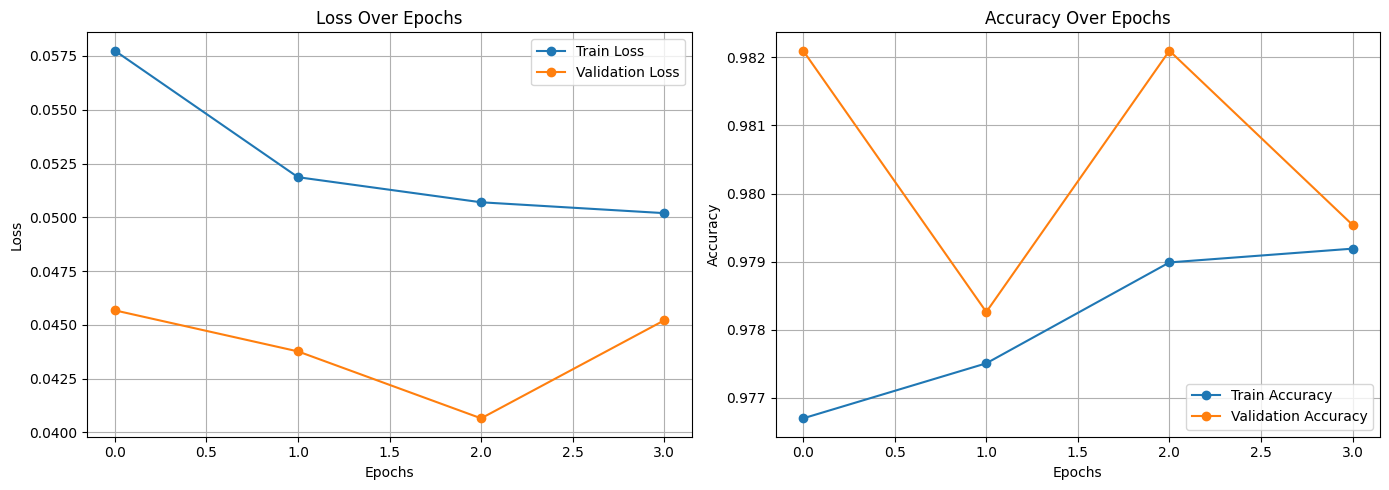

CPU times: user 2min 12s, sys: 5.89 s, total: 2min 18s
Wall time: 1min 58s


In [145]:
%%time
keras.utils.set_random_seed(7927)
LSTM7927 = pipeline(model)

# **RNN Network**

In [146]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model_rnn = Sequential()

model_rnn.add(Input(shape=(sequence_length, nb_features)))
model_rnn.add(SimpleRNN(units=100, return_sequences=True))
model_rnn.add(Dropout(0.2))

model_rnn.add(SimpleRNN(units=100, return_sequences=False))  # Исправлено
model_rnn.add(Dropout(0.2))

model_rnn.add(Dense(units=nb_out, activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [147]:
print(model_rnn.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)             │ (None, 50, 100)             │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,801 (128.13 KB)

 Trainable params: 32,801 (128.13 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.8483 - loss: 0.3407 - val_accuracy: 0.9604 - val_loss: 0.1141
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9391 - loss: 0.1443 - val_accuracy: 0.9463 - val_loss: 0.1055
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.9554 - loss: 0.1089 - val_accuracy: 0.9591 - val_loss: 0.1003
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.9608 - loss: 0.0906 - val_accuracy: 0.9668 - val_loss: 0.0749
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.9608 - loss: 0.0940 - val_accuracy: 0.9680 - val_loss: 0.0721
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.9714 - loss: 0.0700 - val_accuracy: 0.9757 - val_loss: 0.0603
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.9680 - loss: 0.0781 - val_accuracy: 0.9680 - val_loss: 0.0719
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.961

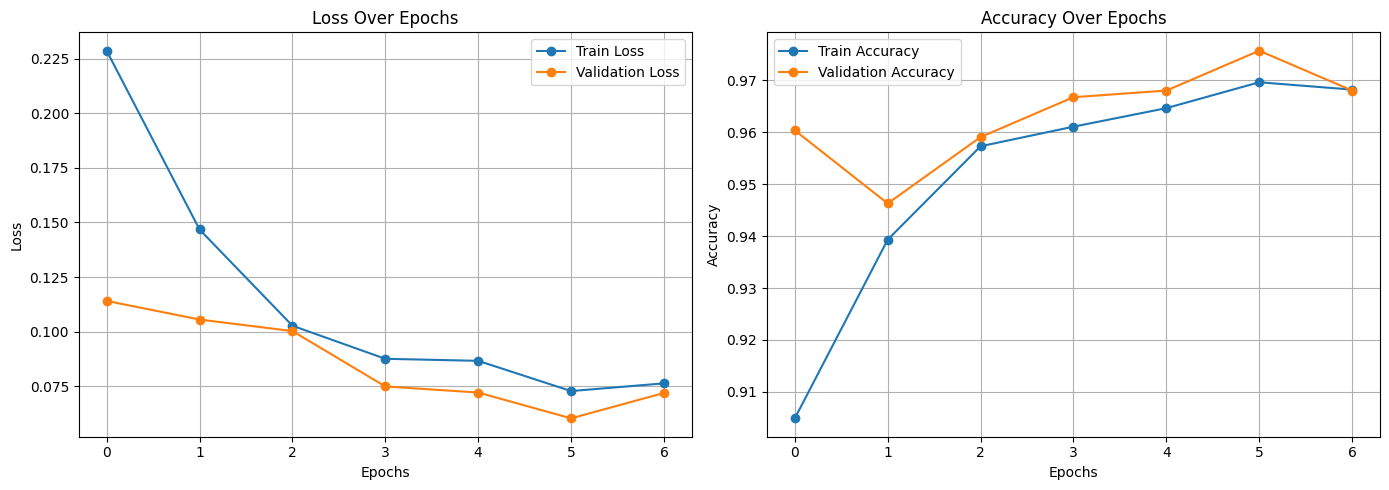

CPU times: user 1min 54s, sys: 5.47 s, total: 2min
Wall time: 1min 44s


In [148]:
%%time
RNN = pipeline(model_rnn)

# **GRU Network**

In [149]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model_gru = Sequential()

model_gru.add(Input(shape=(sequence_length, nb_features)))
model_gru.add(GRU(units=100, return_sequences=True))
model_gru.add(Dropout(0.2))

model_gru.add(GRU(units=100, return_sequences=False))  # Исправлено
model_gru.add(Dropout(0.2))

model_gru.add(Dense(units=nb_out, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [150]:
print(model_gru.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                          │ (None, 50, 100)             │          38,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 100)                 │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,801 (385.94 KB)

 Trainable params: 98,801 (385.94 KB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 374ms/step - accuracy: 0.8196 - loss: 0.3754 - val_accuracy: 0.9373 - val_loss: 0.1322
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 369ms/step - accuracy: 0.9458 - loss: 0.1251 - val_accuracy: 0.9604 - val_loss: 0.0772
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - accuracy: 0.9620 - loss: 0.0813 - val_accuracy: 0.9616 - val_loss: 0.0838
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.9601 - loss: 0.0838
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9785 - loss: 0.0570


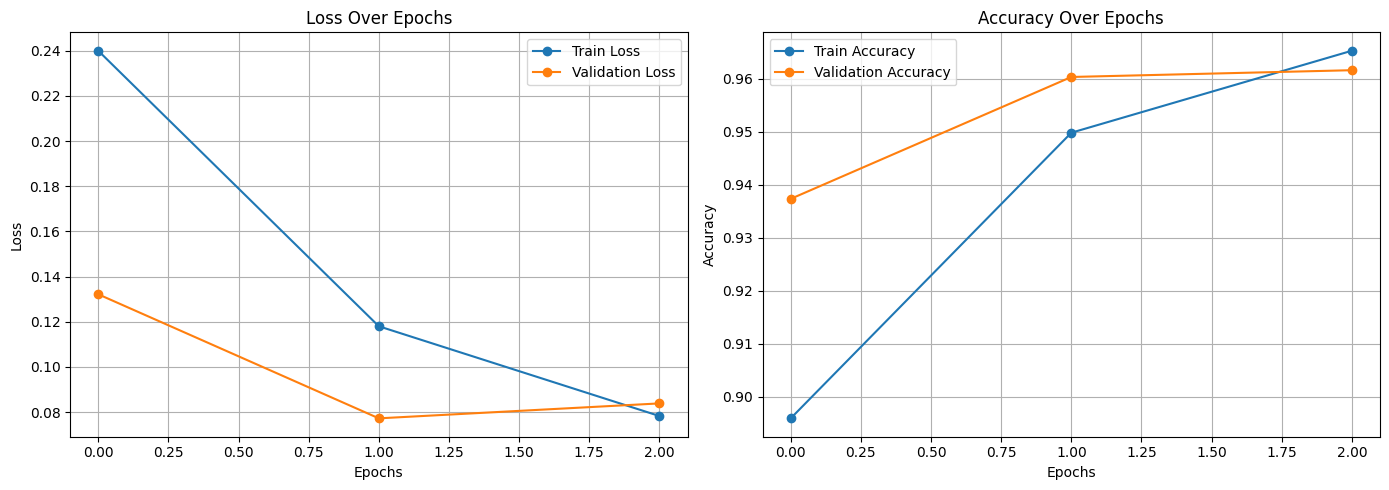

CPU times: user 2min 34s, sys: 6.78 s, total: 2min 41s
Wall time: 2min 27s


In [151]:
%%time
GRU_res = pipeline(model_gru)

# **Results**

In [152]:
results_df = pd.DataFrame([
                                LSTM1234["train"],
                                LSTM1234["test"],
                                LSTM1159["train"],
                                LSTM1159["test"],
                                LSTM5858["train"],
                                LSTM5858["test"],
                                LSTM7927["train"],
                                LSTM7927["test"],
                                RNN["train"],
                                RNN["test"],
                                GRU_res["train"],
                                GRU_res["test"],
                          ],
                            columns=["Accuracy", "Precision", "Recall", "F1-score", "Loss"],
                            index=[
                                "LSTM (seed:1234) train",
                                "LSTM (seed:1234) test",
                                "LSTM (seed:1159) train",
                                "LSTM (seed:1159) test",
                                "LSTM (seed:5858) train",
                                "LSTM (seed:5858) test",
                                "LSTM (seed:7927) train",
                                "LSTM (seed:7927) test",
                                "RNN train",
                                "RNN test",
                                "GRU train",
                                "GRU test",
                                ],
                          )
results_df

,Accuracy,Precision,Recall,F1-score,Loss
LSTM (seed:1234) train,0.966413,0.992352,0.837097,0.908136,0.078772
LSTM (seed:1234) test,0.956989,1.000000,0.840000,0.913043,0.117384
LSTM (seed:1159) train,0.938584,0.999067,0.690968,0.816934,0.156131
LSTM (seed:1159) test,0.903226,1.000000,0.640000,0.780488,0.194991
LSTM (seed:5858) train,0.966029,0.861322,0.987742,0.920210,0.079675
LSTM (seed:5858) test,0.978495,0.925926,1.000000,0.961538,0.079565
LSTM (seed:7927) train,0.975753,0.909173,0.975161,0.941012,0.056254
LSTM (seed:7927) test,0.967742,0.892857,1.000000,0.943396,0.057116
RNN train,0.965453,0.857542,0.990323,0.919162,0.079494
RNN test,0.956989,0.888889,0.960000,0.923077,0.077978
